In [44]:
globals().clear()

# Importing necessary libraries for analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set plotting font to Segoe UI (font used for the report)
plt.rcParams['font.family'] = 'Segoe UI'

# Load the dataset
df = pd.read_csv("FeaturesSelected.csv")

In [45]:
# ENCODING TECHNIQUES

from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

# Select categoric and numeric columns
categorical_features = df.select_dtypes(include=['object', 'category']).columns
categorical_df = df[categorical_features]
numerical_features = df.select_dtypes(include=['Int32', 'Int64', 'Float64']).columns
numerical_df = df[numerical_features]

# Encode categoric values
encoded_categorical_df = categorical_df.copy()

target = 'Price'
encoded_categorical_df = categorical_df.copy()
for col in categorical_features:
    encoded_categorical_df[col] = encoded_categorical_df[col].map(df.groupby(col)[target].mean())

df_encoded = pd.concat([encoded_categorical_df, numerical_df], axis=1)

#print(df_encoded.columns)

In [46]:
# GET OPTIMUM FEATURES

correlation_matrix = df_encoded.corr()
correlation_coeff = correlation_matrix['Price']
filtered_features = correlation_coeff[correlation_coeff > 0.1].index
df_encoded = df_encoded[filtered_features]

#print(filtered_features)

In [47]:
# EFFECT OF ENCODING TECHNIQUES

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, median_absolute_error


# SPLIT TRAIN AND TEST DATA
X = df_encoded.drop(columns=['Price'])
y = df_encoded['Price'].values.reshape(-1, 1) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# HYPERPARAMETER TUNING
# param_grid = {'max_depth': [3, 5, 10, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 5, 10]}
# grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_
# print("Best parameters:", best_params)

# MODEL TRAINING WITH BEST PARAMETERS
model = DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 5, min_samples_split = 2 , random_state=42)
model.fit(X_train, y_train)

# MODEL EVALUATION
y_pred = model.predict(X_test)


# MODEL METRICS PERFORMANCE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
medae = median_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
r2 = r2_score(y_test, y_pred)

print(f"""
Model Performance:
-------------------
Mean Absolute Error (MAE): {mae:.2f}
Root Mean Squared Error (RMSE): {rmse:.2f}
Median Absolute Error (MedAE): {medae:.2f}
Mean Absolute Percentage Error (MAPE): {mape:.2f}%
R² Score: {r2:.4f}
""")


Model Performance:
-------------------
Mean Absolute Error (MAE): 136970.76
Root Mean Squared Error (RMSE): 404572.10
Median Absolute Error (MedAE): 33542.73
Mean Absolute Percentage Error (MAPE): 27.39%
R² Score: 0.9220



In [48]:
# EFFECT OF PRICE TRANSFORMATION

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, median_absolute_error

from scipy.stats import boxcox


# TRANSFORMATION OF PRICE COLUMN
df_encoded_transf = df_encoded.copy()
df_encoded_transf['Price_transf'], lambda_bc = boxcox(np.maximum(df_encoded['Price'], 1e-5))


# SPLIT TRAIN AND TEST DATA
X = df_encoded_transf.drop(columns=['Price_transf', 'Price'])
y = df_encoded_transf['Price_transf'].values.reshape(-1, 1) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# MODEL TRAINING
model = DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 5, min_samples_split = 2 , random_state=42)
model.fit(X_train, y_train)


# MODEL EVALUATION
y_pred = model.predict(X_test)


# REVERSE TRANSFORAMTION
if lambda_bc == 0:
    y_pred = np.expm1(y_pred) 
    y_test_original = np.expm1(y_test)
else:
    y_pred = (lambda_bc * y_pred + 1) ** (1 / lambda_bc) 
    y_test_original = (lambda_bc * y_test + 1) ** (1 / lambda_bc)


# MODEL METRICS PERFORMANCE
mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
medae = median_absolute_error(y_test_original, y_pred)
mape = mean_absolute_percentage_error(y_test_original, y_pred) * 100
r2 = r2_score(y_test_original, y_pred)

print(f"""
Model Performance:
-------------------
Mean Absolute Error (MAE): {mae:.2f}
Root Mean Squared Error (RMSE): {rmse:.2f}
Median Absolute Error (MedAE): {medae:.2f}
Mean Absolute Percentage Error (MAPE): {mape:.2f}%
R² Score: {r2:.4f}
""")


Model Performance:
-------------------
Mean Absolute Error (MAE): 148878.31
Root Mean Squared Error (RMSE): 438397.39
Median Absolute Error (MedAE): 34655.52
Mean Absolute Percentage Error (MAPE): 28.72%
R² Score: 0.9084



In [49]:
# EFFECT OF SCALING TECHNIQUES

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, median_absolute_error

from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, Normalizer, QuantileTransformer


# SPLIT TRAIN AND TEST DATA
X = df_encoded.drop(columns=['Price'])
y = df_encoded['Price'].values.reshape(-1, 1) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# SCALE DATA (norm='l2' for Normalizer, output_distribution='normal', random_state=42 for QuantileTransformer)
scaler_x = Normalizer(norm='l2')
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)


# MODEL TRAINING
model = DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 5, min_samples_split = 2 , random_state=42)
model.fit(X_train_scaled, y_train_scaled)


# MODEL EVALUATION
y_pred_scaled = model.predict(X_test_scaled)


# GOING BACK TO ORIGINAL SCALE
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()



# MODEL METRICS PERFORMANCE
mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
medae = median_absolute_error(y_test_original, y_pred)
mape = mean_absolute_percentage_error(y_test_original, y_pred) * 100
r2 = r2_score(y_test_original, y_pred)

print(f"""
Model Performance:
-------------------
Mean Absolute Error (MAE): {mae:.2f}
Root Mean Squared Error (RMSE): {rmse:.2f}
Median Absolute Error (MedAE): {medae:.2f}
Mean Absolute Percentage Error (MAPE): {mape:.2f}%
R² Score: {r2:.4f}
""")


Model Performance:
-------------------
Mean Absolute Error (MAE): 137172.39
Root Mean Squared Error (RMSE): 368740.02
Median Absolute Error (MedAE): 37066.66
Mean Absolute Percentage Error (MAPE): 30.81%
R² Score: 0.9352



In [50]:
# MOST ACCURATE DECISION TREE MODEL

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, median_absolute_error

from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, Normalizer, QuantileTransformer


# TRANSFORMATION OF PRICE COLUMN
df_encoded_transf = df_encoded.copy()
df_encoded_transf['Price_transf'], lambda_bc = boxcox(np.maximum(df_encoded['Price'], 1e-5))


# SPLIT TRAIN AND TEST DATA
X = df_encoded.drop(columns=['Price'])
y = df_encoded['Price'].values.reshape(-1, 1) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# SCALE DATA (norm='l2' for Normalizer, output_distribution='normal', random_state=42 for QuantileTransformer)
scaler_x =  StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)


# HYPERPARAMETER TUNING
param_grid = {'max_depth': [3, 5, 10, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 5, 10]}
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_scaled)
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# MODEL TRAINING WITH BEST PARAMETERS
model = DecisionTreeRegressor(**best_params, random_state=42)
model.fit(X_train_scaled, y_train_scaled)


# MODEL EVALUATION
y_pred_scaled = model.predict(X_test_scaled)


# GOING BACK TO ORIGINAL SCALE
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()


# REVERSE TRANSFORAMTION
# if lambda_bc == 0:
#     y_pred = np.expm1(y_pred) 
#     y_test_original = np.expm1(y_test)
# else:
#     y_pred = (lambda_bc * y_pred + 1) ** (1 / lambda_bc) 
#     y_test_original = (lambda_bc * y_test + 1) ** (1 / lambda_bc)


# MODEL METRICS PERFORMANCE
mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
medae = median_absolute_error(y_test_original, y_pred)
mape = mean_absolute_percentage_error(y_test_original, y_pred) * 100
r2 = r2_score(y_test_original, y_pred)

print(f"""
Model Performance:
-------------------
Mean Absolute Error (MAE): {mae:.2f}
Root Mean Squared Error (RMSE): {rmse:.2f}
Median Absolute Error (MedAE): {medae:.2f}
Mean Absolute Percentage Error (MAPE): {mape:.2f}%
R² Score: {r2:.4f}
""")

Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}

Model Performance:
-------------------
Mean Absolute Error (MAE): 122142.33
Root Mean Squared Error (RMSE): 327207.78
Median Absolute Error (MedAE): 30000.00
Mean Absolute Percentage Error (MAPE): 24.82%
R² Score: 0.9490



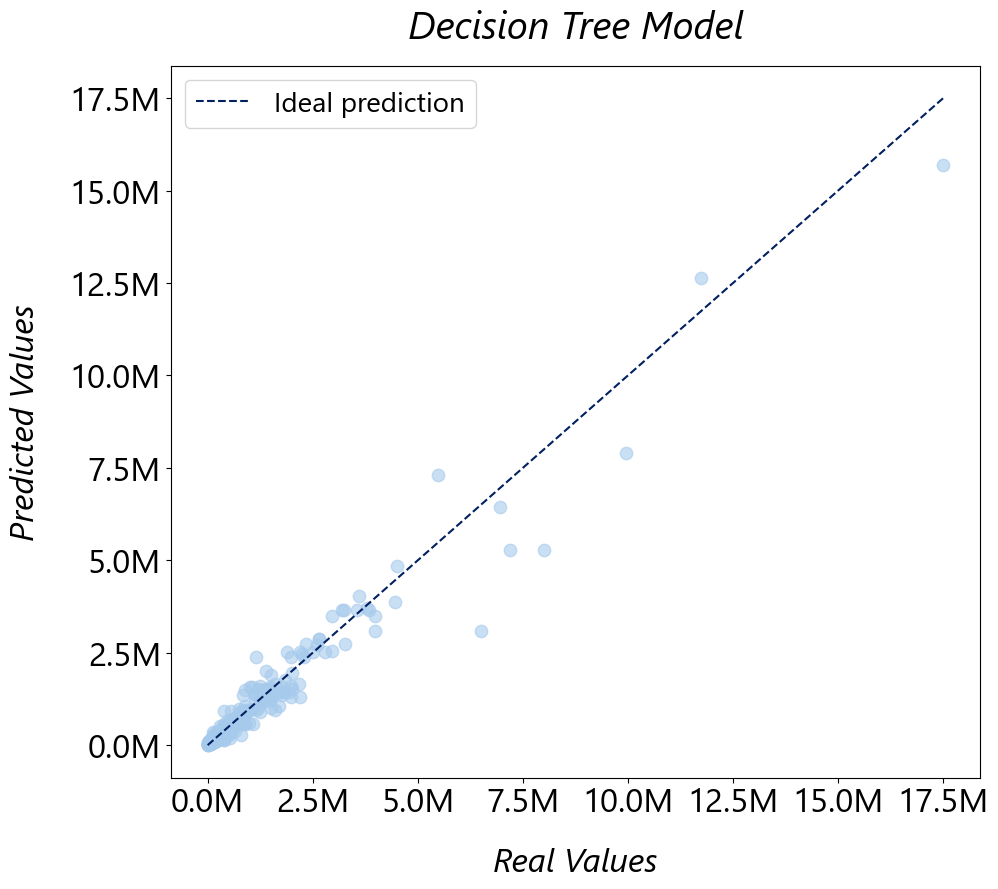

In [ ]:
# DECISION TREE MODEL PERFORMANCE VISUALIZATION

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Create figure 
fig, ax = plt.subplots(figsize=(10, 9))

# Scatter plot
ax.scatter(y_test_original, y_pred, s=80, c='#A6CAEC',alpha=0.6, edgecolor='#A6CAEC')
ax.plot([min(y_test_original), max(y_test_original)],
        [min(y_test_original), max(y_test_original)],
         linestyle='--', color='#002060',label='Ideal prediction')

# Labels and title
ax.set_xlabel('Real Values', fontsize=24, fontname='Segoe UI', fontstyle='italic', labelpad=20)
ax.set_ylabel('Predicted Values', fontsize=24, fontname='Segoe UI', fontstyle='italic', labelpad=20)
ax.tick_params(axis='both', which='major', labelsize=24)

# Axis format
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))

# Offset font
ax.yaxis.get_offset_text().set_fontsize(24)
ax.xaxis.get_offset_text().set_fontsize(24)
ax.set_title('Decision Tree Model', fontsize=28, fontstyle='italic', fontname='Segoe UI', pad=20)

ax.legend(fontsize=20)
plt.tight_layout()
plt.show()

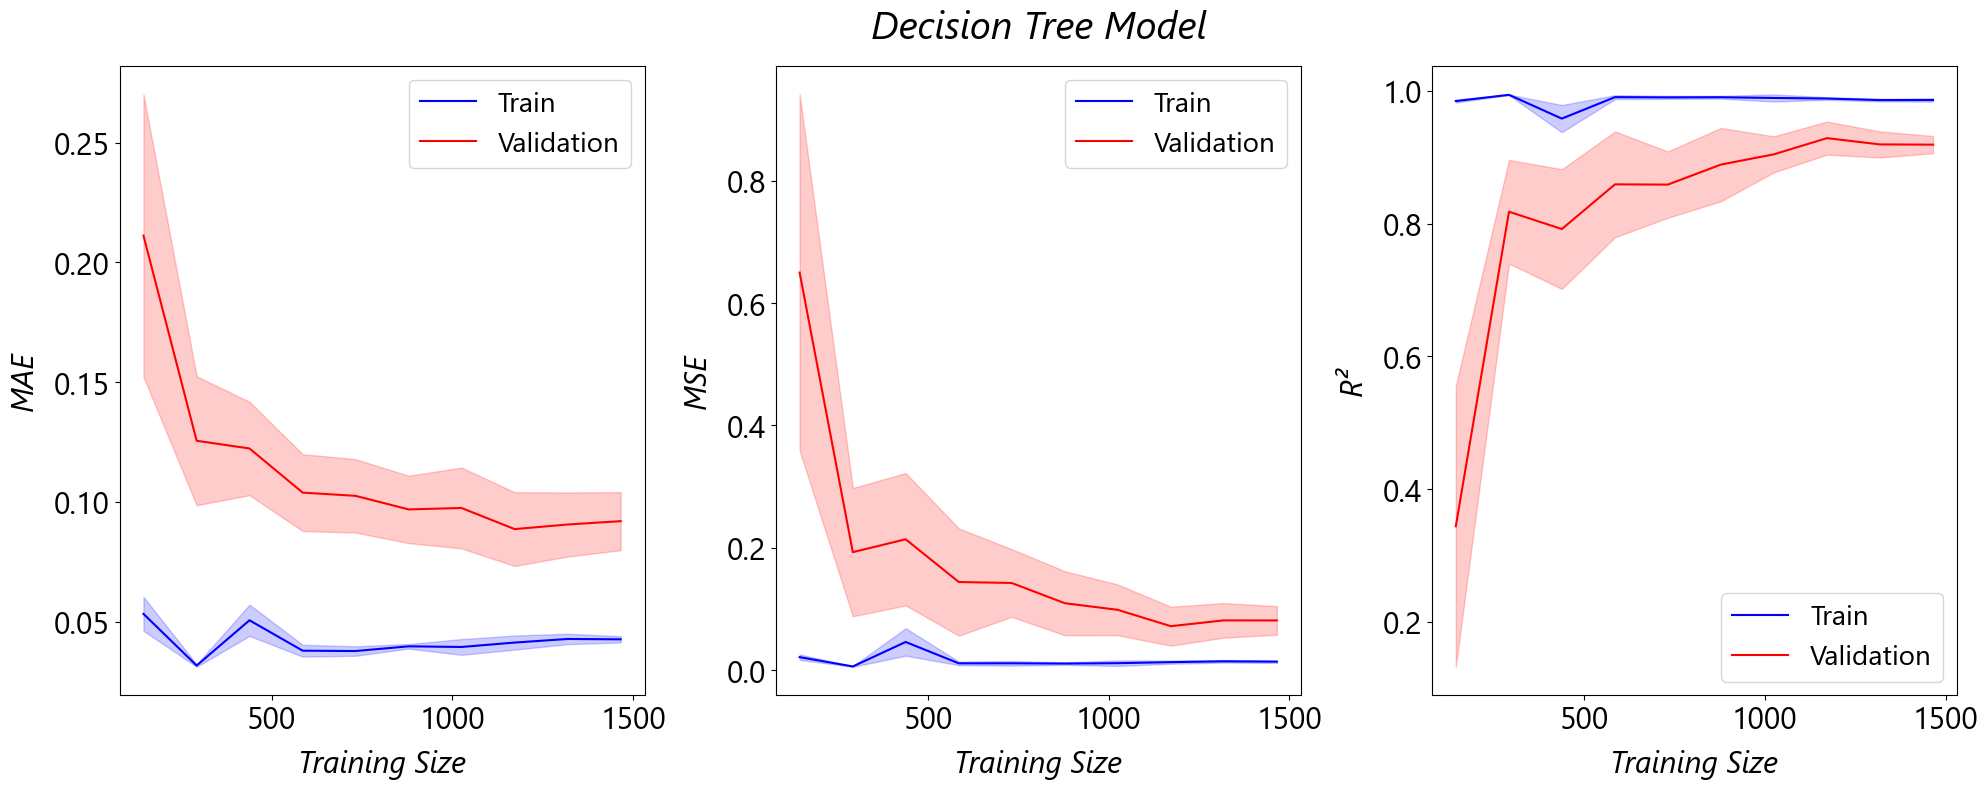

In [ ]:
# DECISION TREE MODEL VALIDATION

from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import learning_curve

# Define metrics
scoring_mae = make_scorer(mean_absolute_error)
scoring_mse = make_scorer(mean_squared_error)
scoring_r2 = make_scorer(r2_score)

# Learning of curves for each of the metrics
train_sizes, train_scores_mae, valid_scores_mae = learning_curve(
    model, X_train_scaled, y_train_scaled, cv=5, scoring=scoring_mae, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)
train_sizes, train_scores_mse, valid_scores_mse = learning_curve(
    model, X_train_scaled, y_train_scaled, cv=5, scoring=scoring_mse, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)
train_sizes, train_scores_r2, valid_scores_r2 = learning_curve(
    model, X_train_scaled, y_train_scaled, cv=5, scoring=scoring_r2, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Compute means and standard deviations
train_mean_mae = train_scores_mae.mean(axis=1)
valid_mean_mae = valid_scores_mae.mean(axis=1)
train_mean_mse = train_scores_mse.mean(axis=1)
valid_mean_mse = valid_scores_mse.mean(axis=1)
train_mean_r2 = train_scores_r2.mean(axis=1)
valid_mean_r2 = valid_scores_r2.mean(axis=1)

train_std_mae = train_scores_mae.std(axis=1)
valid_std_mae = valid_scores_mae.std(axis=1)
train_std_mse = train_scores_mse.std(axis=1)
valid_std_mse = valid_scores_mse.std(axis=1)
train_std_r2 = train_scores_r2.std(axis=1)
valid_std_r2 = valid_scores_r2.std(axis=1)


mae_scaled = mean_absolute_error(y_test_scaled, y_pred_scaled)
mse_scaled = mean_squared_error(y_test_scaled, y_pred_scaled)
r2_scaled = r2_score(y_test_scaled, y_pred_scaled)


# Plot learning curves for MAE, MSE y R²
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# MAE
axs[0].plot(train_sizes, train_mean_mae, label="Train", color="blue")
axs[0].plot(train_sizes, valid_mean_mae, label="Validation", color="red")
axs[0].fill_between(train_sizes, train_mean_mae - train_std_mae, train_mean_mae + train_std_mae, color="blue", alpha=0.2)
axs[0].fill_between(train_sizes, valid_mean_mae - valid_std_mae, valid_mean_mae + valid_std_mae, color="red", alpha=0.2)
axs[0].set_xlabel("Training Size", fontsize=22, fontname='Segoe UI', fontstyle='italic', labelpad=10)
axs[0].set_ylabel("MAE", fontsize=22, fontname='Segoe UI', fontstyle='italic', labelpad=10)
axs[0].tick_params(axis='both', which='major', labelsize=22)
axs[0].legend(fontsize=20)

# MSE
axs[1].plot(train_sizes, train_mean_mse, label="Train", color="blue")
axs[1].plot(train_sizes, valid_mean_mse, label="Validation", color="red")
axs[1].fill_between(train_sizes, train_mean_mse - train_std_mse, train_mean_mse + train_std_mse, color="blue", alpha=0.2)
axs[1].fill_between(train_sizes, valid_mean_mse - valid_std_mse, valid_mean_mse + valid_std_mse, color="red", alpha=0.2)
axs[1].set_title("Decision Tree Model", fontsize=28, fontstyle='italic', fontname='Segoe UI', pad=20)
axs[1].set_xlabel("Training Size", fontsize=22, fontname='Segoe UI', fontstyle='italic', labelpad=10)
axs[1].set_ylabel("MSE", fontsize=22, fontname='Segoe UI', fontstyle='italic', labelpad=10)
axs[1].tick_params(axis='both', which='major', labelsize=22)
axs[1].legend(fontsize=20)

# R²
axs[2].plot(train_sizes, train_mean_r2, label="Train", color="blue")
axs[2].plot(train_sizes, valid_mean_r2, label="Validation", color="red")
axs[2].fill_between(train_sizes, train_mean_r2 - train_std_r2, train_mean_r2 + train_std_r2, color="blue", alpha=0.2)
axs[2].fill_between(train_sizes, valid_mean_r2 - valid_std_r2, valid_mean_r2 + valid_std_r2, color="red", alpha=0.2)
axs[2].set_xlabel("Training Size", fontsize=22, fontname='Segoe UI', fontstyle='italic', labelpad=10)
axs[2].set_ylabel("R²", fontsize=22, fontname='Segoe UI', fontstyle='italic', labelpad=10)
axs[2].tick_params(axis='both', which='major', labelsize=22)
axs[2].legend(fontsize=20)

plt.tight_layout()
plt.show()

In [53]:
# import matplotlib.pyplot as plt
# from sklearn.tree import plot_tree

# # PLOT DECISION TREE
# plt.figure(figsize=(20, 10))
# plot_tree(model, feature_names=X.columns, filled=True, rounded=True)
# plt.show()

In [54]:
# MOST ACCURATE RANDOM FOREST MODEL

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, median_absolute_error

from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, Normalizer, QuantileTransformer


# TRANSFORMATION OF PRICE COLUMN
df_encoded_transf = df_encoded.copy()
df_encoded_transf['Price_transf'] = np.log1p(df_encoded['Price'])


# SPLIT TRAIN AND TEST DATA
X = df_encoded.drop(columns=['Price'])
y = df_encoded['Price'].values.reshape(-1, 1) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# SCALE DATA (norm='l2' for Normalizer, output_distribution='normal', random_state=42 for QuantileTransformer)
scaler_x =  QuantileTransformer(output_distribution='normal', random_state=42)
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = QuantileTransformer(output_distribution='normal', random_state=42)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)


# HYPERPARAMETER TUNING
param_grid = {
    'n_estimators': [100, 200, 500],  # Number of trees in the forest
    'max_depth': [3, 5, 10, None],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 5, 10],  # Minimum samples at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at each split
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_scaled)
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# MODEL TRAINING WITH BEST PARAMETERS
model = RandomForestRegressor(**best_params, random_state=42)
model.fit(X_train_scaled, y_train_scaled)


# MODEL EVALUATION
y_pred_scaled = model.predict(X_test_scaled)


# GOING BACK TO ORIGINAL SCALE
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()


# REVERSE TRANSFORAMTION
# y_pred = np.expm1(y_pred)
# y_test_original = np.expm1(y_test)


# MODEL METRICS PERFORMANCE
mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
medae = median_absolute_error(y_test_original, y_pred)
mape = mean_absolute_percentage_error(y_test_original, y_pred) * 100
r2 = r2_score(y_test_original, y_pred)

print(f"""
Model Performance:
-------------------
Mean Absolute Error (MAE): {mae:.2f}
Root Mean Squared Error (RMSE): {rmse:.2f}
Median Absolute Error (MedAE): {medae:.2f}
Mean Absolute Percentage Error (MAPE): {mape:.2f}%
R² Score: {r2:.4f}
""")

c:\Users\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best parameters: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}


C:\Users\Ángela Martín Milán\AppData\Local\Temp\ipykernel_2524\3544612539.py:47: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled, y_train_scaled)



Model Performance:
-------------------
Mean Absolute Error (MAE): 110296.73
Root Mean Squared Error (RMSE): 289836.99
Median Absolute Error (MedAE): 30059.26
Mean Absolute Percentage Error (MAPE): 23.81%
R² Score: 0.9585



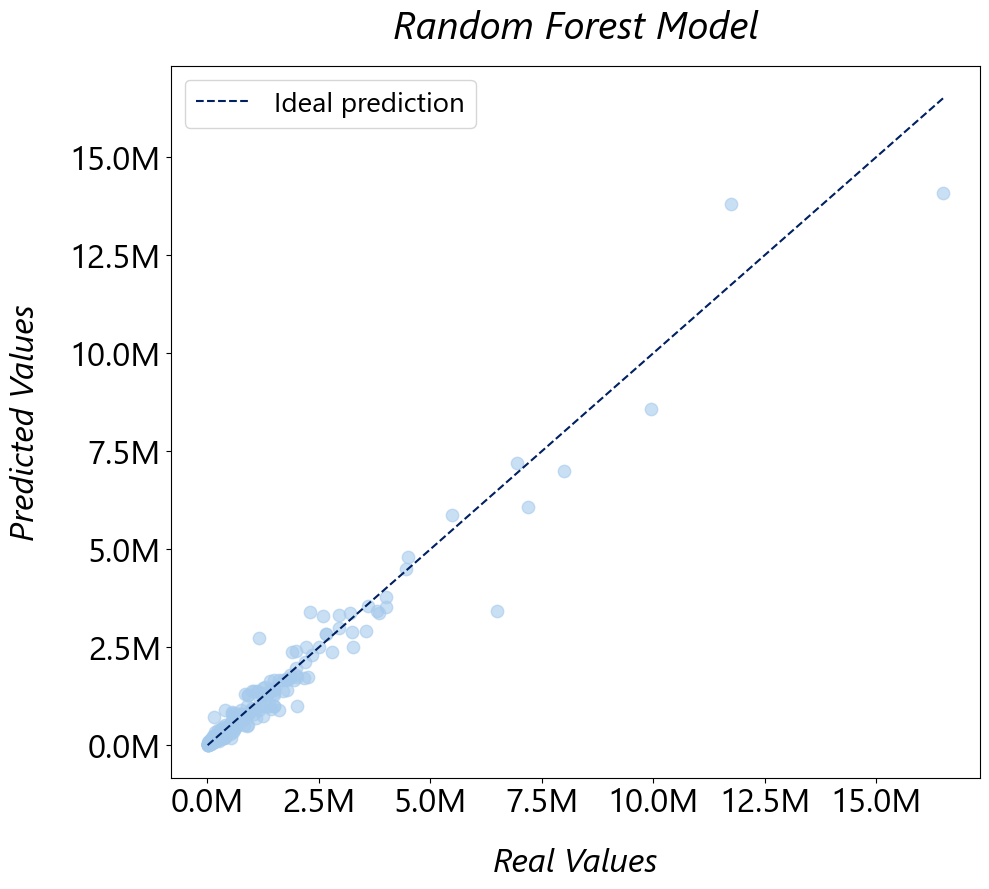

In [ ]:
# RANDOM FOREST MODEL PERFORMANCE VISUALIZATION

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Create figure
fig, ax = plt.subplots(figsize=(10, 9))

# Scatter plot
ax.scatter(y_test_original, y_pred, s=80, c='#A6CAEC',alpha=0.6, edgecolor='#A6CAEC')
ax.plot([min(y_test_original), max(y_test_original)],
        [min(y_test_original), max(y_test_original)],
         linestyle='--', color='#002060',label='Ideal prediction')

# Labels and title
ax.set_xlabel('Real Values', fontsize=24, fontname='Segoe UI', fontstyle='italic', labelpad=20)
ax.set_ylabel('Predicted Values', fontsize=24, fontname='Segoe UI', fontstyle='italic', labelpad=20)
ax.tick_params(axis='both', which='major', labelsize=24)

# FAxis format
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))

# Offset font
ax.yaxis.get_offset_text().set_fontsize(24)
ax.xaxis.get_offset_text().set_fontsize(24)
ax.set_title('Random Forest Model', fontsize=28, fontstyle='italic', fontname='Segoe UI', pad=20)

ax.legend(fontsize=20)
plt.tight_layout()
plt.show()

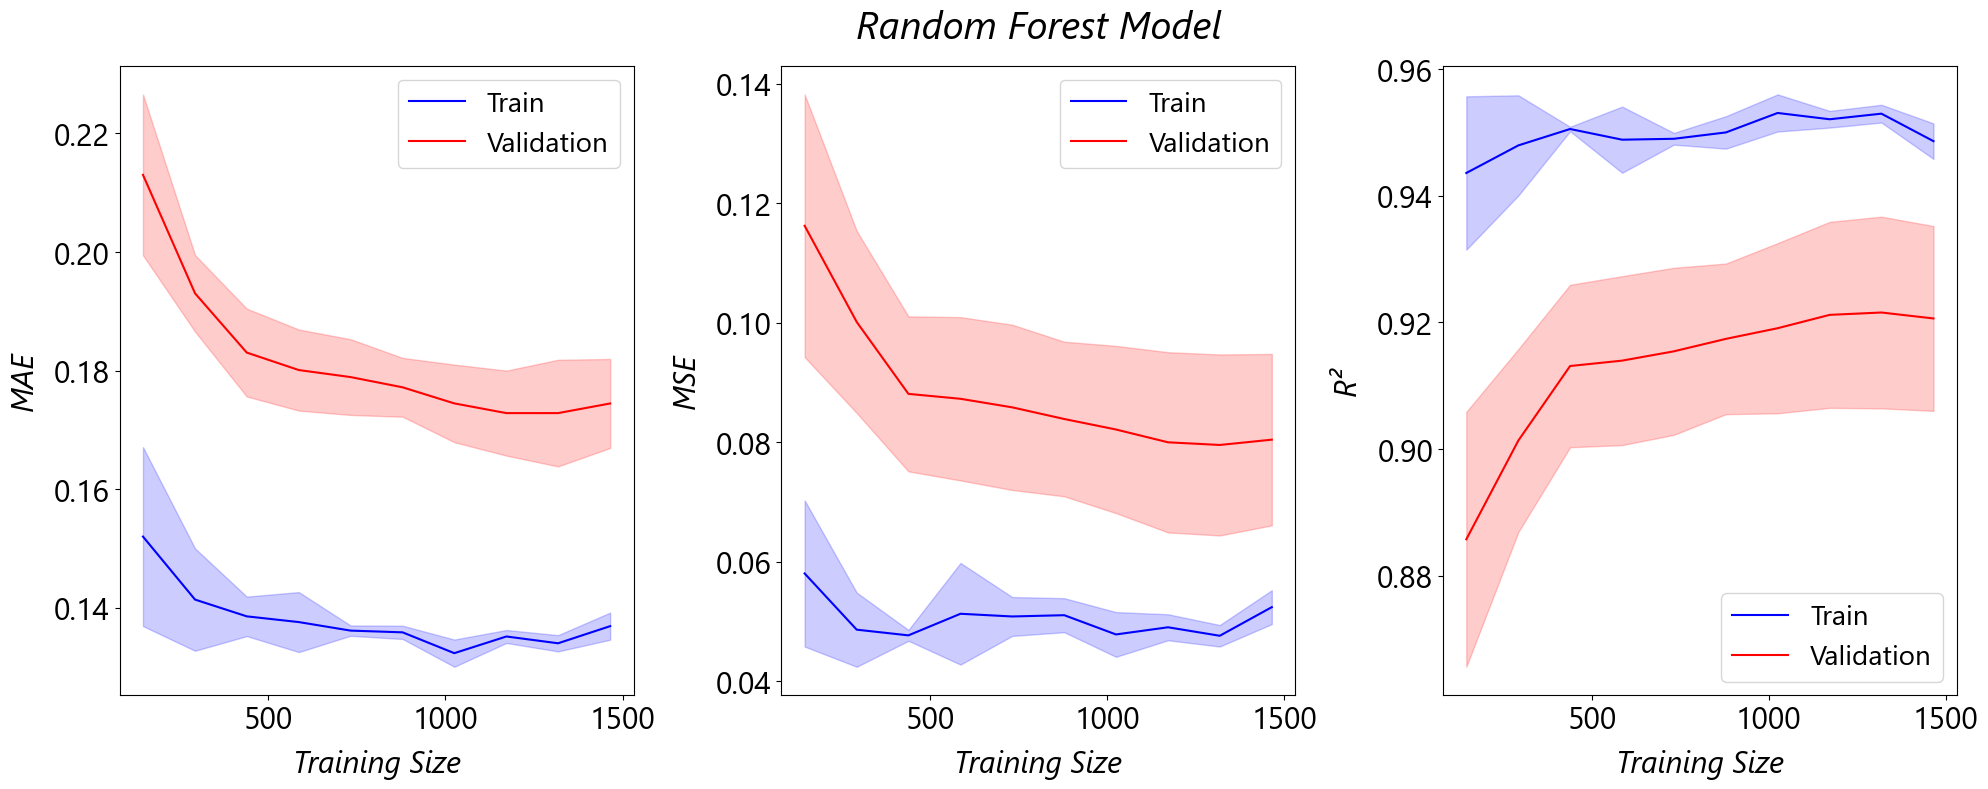

In [ ]:
# RANDOM FOREST MODEL VALIDATION

from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import learning_curve

# Define metrics
scoring_mae = make_scorer(mean_absolute_error)
scoring_mse = make_scorer(mean_squared_error)
scoring_r2 = make_scorer(r2_score)

# Learning of curves for each of the metrics
train_sizes, train_scores_mae, valid_scores_mae = learning_curve(
    model, X_train_scaled, y_train_scaled, cv=5, scoring=scoring_mae, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)
train_sizes, train_scores_mse, valid_scores_mse = learning_curve(
    model, X_train_scaled, y_train_scaled, cv=5, scoring=scoring_mse, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)
train_sizes, train_scores_r2, valid_scores_r2 = learning_curve(
    model, X_train_scaled, y_train_scaled, cv=5, scoring=scoring_r2, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Compute means and standard deviations
train_mean_mae = train_scores_mae.mean(axis=1)
valid_mean_mae = valid_scores_mae.mean(axis=1)
train_mean_mse = train_scores_mse.mean(axis=1)
valid_mean_mse = valid_scores_mse.mean(axis=1)
train_mean_r2 = train_scores_r2.mean(axis=1)
valid_mean_r2 = valid_scores_r2.mean(axis=1)

train_std_mae = train_scores_mae.std(axis=1)
valid_std_mae = valid_scores_mae.std(axis=1)
train_std_mse = train_scores_mse.std(axis=1)
valid_std_mse = valid_scores_mse.std(axis=1)
train_std_r2 = train_scores_r2.std(axis=1)
valid_std_r2 = valid_scores_r2.std(axis=1)


mae_scaled = mean_absolute_error(y_test_scaled, y_pred_scaled)
mse_scaled = mean_squared_error(y_test_scaled, y_pred_scaled)
r2_scaled = r2_score(y_test_scaled, y_pred_scaled)


# Plot learning curves for MAE, MSE y R²
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# MAE
axs[0].plot(train_sizes, train_mean_mae, label="Train", color="blue")
axs[0].plot(train_sizes, valid_mean_mae, label="Validation", color="red")
axs[0].fill_between(train_sizes, train_mean_mae - train_std_mae, train_mean_mae + train_std_mae, color="blue", alpha=0.2)
axs[0].fill_between(train_sizes, valid_mean_mae - valid_std_mae, valid_mean_mae + valid_std_mae, color="red", alpha=0.2)
axs[0].set_xlabel("Training Size", fontsize=22, fontname='Segoe UI', fontstyle='italic', labelpad=10)
axs[0].set_ylabel("MAE", fontsize=22, fontname='Segoe UI', fontstyle='italic', labelpad=10)
axs[0].tick_params(axis='both', which='major', labelsize=22)
axs[0].legend(fontsize=20)

# MSE
axs[1].plot(train_sizes, train_mean_mse, label="Train", color="blue")
axs[1].plot(train_sizes, valid_mean_mse, label="Validation", color="red")
axs[1].fill_between(train_sizes, train_mean_mse - train_std_mse, train_mean_mse + train_std_mse, color="blue", alpha=0.2)
axs[1].fill_between(train_sizes, valid_mean_mse - valid_std_mse, valid_mean_mse + valid_std_mse, color="red", alpha=0.2)
axs[1].set_title("Random Forest Model", fontsize=28, fontstyle='italic', fontname='Segoe UI', pad=20)
axs[1].set_xlabel("Training Size", fontsize=22, fontname='Segoe UI', fontstyle='italic', labelpad=10)
axs[1].set_ylabel("MSE", fontsize=22, fontname='Segoe UI', fontstyle='italic', labelpad=10)
axs[1].tick_params(axis='both', which='major', labelsize=22)
axs[1].legend(fontsize=20)

# R²
axs[2].plot(train_sizes, train_mean_r2, label="Train", color="blue")
axs[2].plot(train_sizes, valid_mean_r2, label="Validation", color="red")
axs[2].fill_between(train_sizes, train_mean_r2 - train_std_r2, train_mean_r2 + train_std_r2, color="blue", alpha=0.2)
axs[2].fill_between(train_sizes, valid_mean_r2 - valid_std_r2, valid_mean_r2 + valid_std_r2, color="red", alpha=0.2)
axs[2].set_xlabel("Training Size", fontsize=22, fontname='Segoe UI', fontstyle='italic', labelpad=10)
axs[2].set_ylabel("R²", fontsize=22, fontname='Segoe UI', fontstyle='italic', labelpad=10)
axs[2].tick_params(axis='both', which='major', labelsize=22)
axs[2].legend(fontsize=20)

plt.tight_layout()
plt.show()

In [57]:
# MOST ACCURATE GRADIENT BOOSTING MODEL

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, median_absolute_error

from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, Normalizer, QuantileTransformer


# TRANSFORMATION OF PRICE COLUMN
df_encoded_transf = df_encoded.copy()
df_encoded_transf['Price_transf'], lambda_bc = boxcox(np.maximum(df_encoded['Price'], 1e-5))


# SPLIT TRAIN AND TEST DATA
X = df_encoded.drop(columns=['Price'])
y = df_encoded['Price'].values.reshape(-1, 1) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# SCALE DATA (norm='l2' for Normalizer, output_distribution='normal', random_state=42 for QuantileTransformer)
scaler_x =  QuantileTransformer(output_distribution='normal', random_state=42)
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = QuantileTransformer(output_distribution='normal', random_state=42)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)


# HYPERPARAMETER TUNING
param_grid = {
    'n_estimators': [100, 200, 500],  # Number of boosting stages
    'learning_rate': [0.001, 0.01, 0.1],  # Step size shrinking
    'max_depth': [3, 5, 10, None],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 5, 10],  # Minimum samples at a leaf node
}
grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_scaled)
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# MODEL TRAINING WITH BEST PARAMETERS
model = GradientBoostingRegressor(**best_params, random_state=42)
model.fit(X_train_scaled, y_train_scaled)


# MODEL EVALUATION
y_pred_scaled = model.predict(X_test_scaled)


# GOING BACK TO ORIGINAL SCALE
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()


# REVERSE TRANSFORAMTION
# if lambda_bc == 0:
#     y_pred = np.expm1(y_pred) 
#     y_test_original = np.expm1(y_test)
# else:
#     y_pred = (lambda_bc * y_pred + 1) ** (1 / lambda_bc) 
#     y_test_original = (lambda_bc * y_test + 1) ** (1 / lambda_bc)


# MODEL METRICS PERFORMANCE
mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
medae = median_absolute_error(y_test_original, y_pred)
mape = mean_absolute_percentage_error(y_test_original, y_pred) * 100
r2 = r2_score(y_test_original, y_pred)

print(f"""
Model Performance:
-------------------
Mean Absolute Error (MAE): {mae:.2f}
Root Mean Squared Error (RMSE): {rmse:.2f}
Median Absolute Error (MedAE): {medae:.2f}
Mean Absolute Percentage Error (MAPE): {mape:.2f}%
R² Score: {r2:.4f}
""")

c:\Users\Anaconda\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}


c:\Users\Anaconda\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Model Performance:
-------------------
Mean Absolute Error (MAE): 124015.70
Root Mean Squared Error (RMSE): 352802.84
Median Absolute Error (MedAE): 27080.57
Mean Absolute Percentage Error (MAPE): 23.24%
R² Score: 0.9386



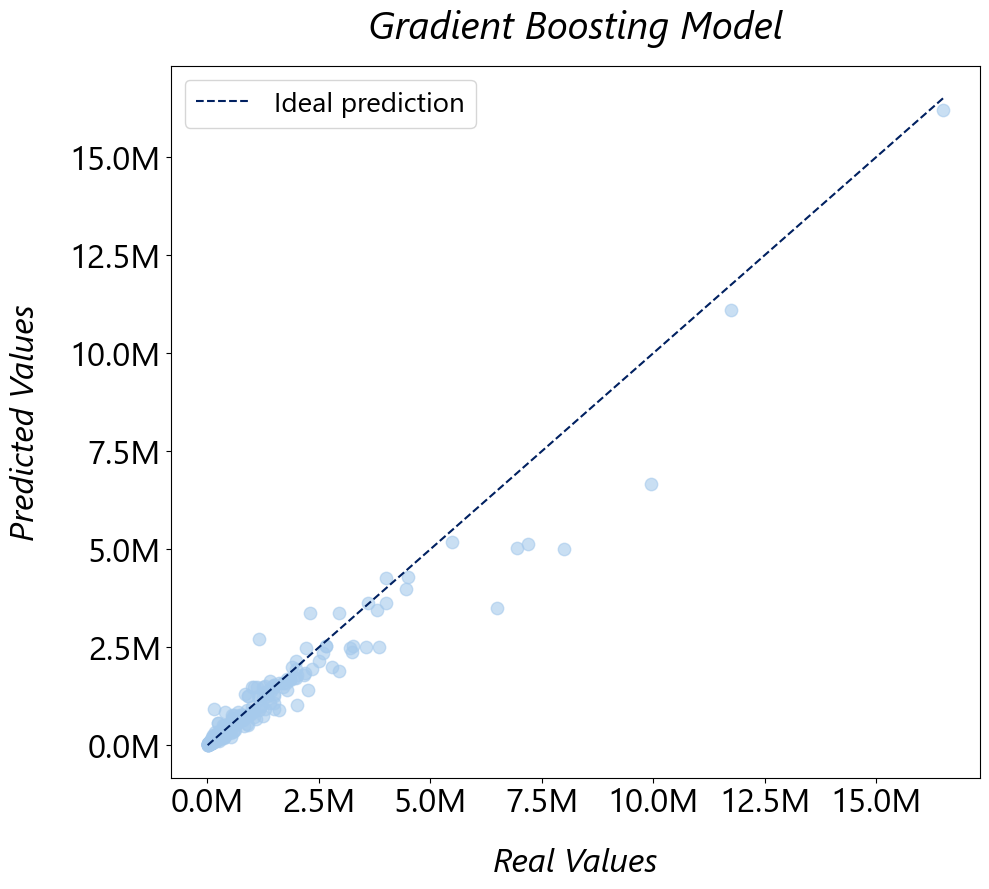

In [ ]:
# GRADIENT BOOSTING MODEL PERFORMANCE VISUALIZATION

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Crear figures
fig, ax = plt.subplots(figsize=(10, 9))

# Scatter plot
ax.scatter(y_test_original, y_pred, s=80, c='#A6CAEC',alpha=0.6, edgecolor='#A6CAEC')
ax.plot([min(y_test_original), max(y_test_original)],
        [min(y_test_original), max(y_test_original)],
         linestyle='--', color='#002060',label='Ideal prediction')

# Labels and title
ax.set_xlabel('Real Values', fontsize=24, fontname='Segoe UI', fontstyle='italic', labelpad=20)
ax.set_ylabel('Predicted Values', fontsize=24, fontname='Segoe UI', fontstyle='italic', labelpad=20)
ax.tick_params(axis='both', which='major', labelsize=24)

# FAxis format
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))

# Offset font
ax.yaxis.get_offset_text().set_fontsize(24)
ax.xaxis.get_offset_text().set_fontsize(24)
ax.set_title('Gradient Boosting Model', fontsize=28, fontstyle='italic', fontname='Segoe UI', pad=20)

ax.legend(fontsize=20)
plt.tight_layout()
plt.show()

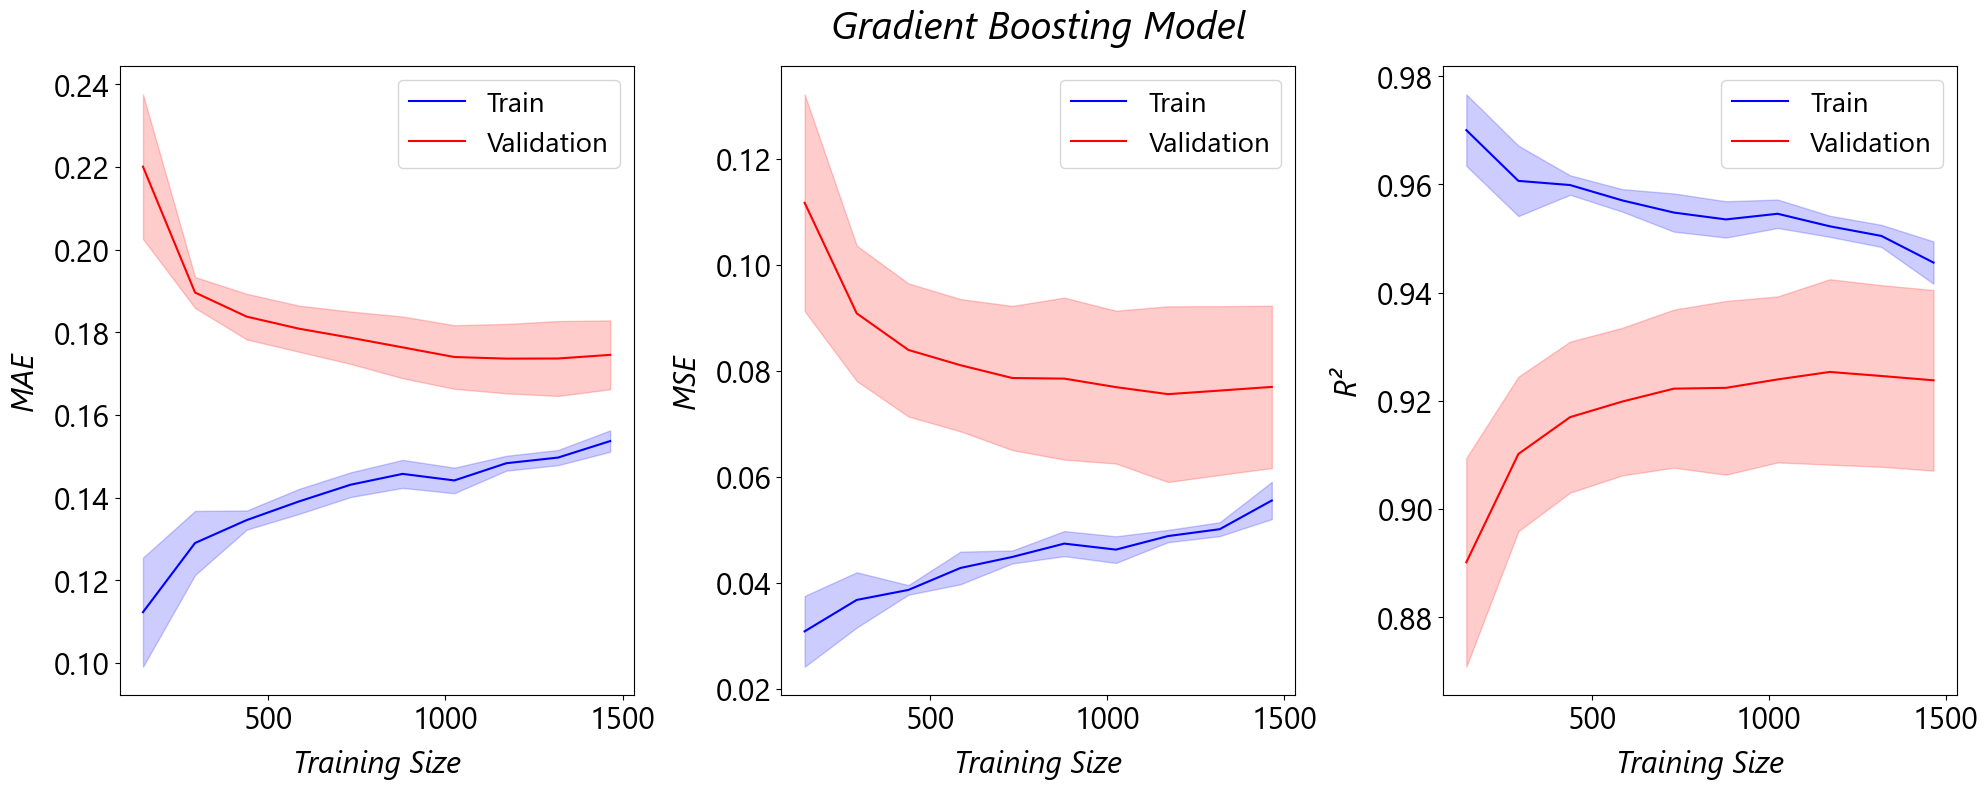

In [ ]:
# GRADIENT BOOSTING MODEL VALIDATION

from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import learning_curve

# Define metrics
scoring_mae = make_scorer(mean_absolute_error)
scoring_mse = make_scorer(mean_squared_error)
scoring_r2 = make_scorer(r2_score)

# Learning of curves for each of the metrics
train_sizes, train_scores_mae, valid_scores_mae = learning_curve(
    model, X_train_scaled, y_train_scaled, cv=5, scoring=scoring_mae, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)
train_sizes, train_scores_mse, valid_scores_mse = learning_curve(
    model, X_train_scaled, y_train_scaled, cv=5, scoring=scoring_mse, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)
train_sizes, train_scores_r2, valid_scores_r2 = learning_curve(
    model, X_train_scaled, y_train_scaled, cv=5, scoring=scoring_r2, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Compute means and standard deviations
train_mean_mae = train_scores_mae.mean(axis=1)
valid_mean_mae = valid_scores_mae.mean(axis=1)
train_mean_mse = train_scores_mse.mean(axis=1)
valid_mean_mse = valid_scores_mse.mean(axis=1)
train_mean_r2 = train_scores_r2.mean(axis=1)
valid_mean_r2 = valid_scores_r2.mean(axis=1)

train_std_mae = train_scores_mae.std(axis=1)
valid_std_mae = valid_scores_mae.std(axis=1)
train_std_mse = train_scores_mse.std(axis=1)
valid_std_mse = valid_scores_mse.std(axis=1)
train_std_r2 = train_scores_r2.std(axis=1)
valid_std_r2 = valid_scores_r2.std(axis=1)


mae_scaled = mean_absolute_error(y_test_scaled, y_pred_scaled)
mse_scaled = mean_squared_error(y_test_scaled, y_pred_scaled)
r2_scaled = r2_score(y_test_scaled, y_pred_scaled)


# Plot learning curves for MAE, MSE y R²
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# MAE
axs[0].plot(train_sizes, train_mean_mae, label="Train", color="blue")
axs[0].plot(train_sizes, valid_mean_mae, label="Validation", color="red")
axs[0].fill_between(train_sizes, train_mean_mae - train_std_mae, train_mean_mae + train_std_mae, color="blue", alpha=0.2)
axs[0].fill_between(train_sizes, valid_mean_mae - valid_std_mae, valid_mean_mae + valid_std_mae, color="red", alpha=0.2)
axs[0].set_xlabel("Training Size", fontsize=22, fontname='Segoe UI', fontstyle='italic', labelpad=10)
axs[0].set_ylabel("MAE", fontsize=22, fontname='Segoe UI', fontstyle='italic', labelpad=10)
axs[0].tick_params(axis='both', which='major', labelsize=22)
axs[0].legend(fontsize=20)

# MSE
axs[1].plot(train_sizes, train_mean_mse, label="Train", color="blue")
axs[1].plot(train_sizes, valid_mean_mse, label="Validation", color="red")
axs[1].fill_between(train_sizes, train_mean_mse - train_std_mse, train_mean_mse + train_std_mse, color="blue", alpha=0.2)
axs[1].fill_between(train_sizes, valid_mean_mse - valid_std_mse, valid_mean_mse + valid_std_mse, color="red", alpha=0.2)
axs[1].set_title("Gradient Boosting Model", fontsize=28, fontstyle='italic', fontname='Segoe UI', pad=20)
axs[1].set_xlabel("Training Size", fontsize=22, fontname='Segoe UI', fontstyle='italic', labelpad=10)
axs[1].set_ylabel("MSE", fontsize=22, fontname='Segoe UI', fontstyle='italic', labelpad=10)
axs[1].tick_params(axis='both', which='major', labelsize=22)
axs[1].legend(fontsize=20)

# R²
axs[2].plot(train_sizes, train_mean_r2, label="Train", color="blue")
axs[2].plot(train_sizes, valid_mean_r2, label="Validation", color="red")
axs[2].fill_between(train_sizes, train_mean_r2 - train_std_r2, train_mean_r2 + train_std_r2, color="blue", alpha=0.2)
axs[2].fill_between(train_sizes, valid_mean_r2 - valid_std_r2, valid_mean_r2 + valid_std_r2, color="red", alpha=0.2)
axs[2].set_xlabel("Training Size", fontsize=22, fontname='Segoe UI', fontstyle='italic', labelpad=10)
axs[2].set_ylabel("R²", fontsize=22, fontname='Segoe UI', fontstyle='italic', labelpad=10)
axs[2].tick_params(axis='both', which='major', labelsize=22)
axs[2].legend(fontsize=20)

plt.tight_layout()
plt.show()